"""
Title: Image Super-Resolution using an Efficient Sub-Pixel CNN
Author: [Xingyu Long](https://github.com/danfyduan)
Date created: 2023/03/30
Last modified: 2023/03/30
Description: Implementing Super-Resolution using Efficient sub-pixel model on HY_IRS.
"""

"""
## Introduction
ESPCN (Efficient Sub-Pixel CNN), proposed by [Shi, 2016](https://arxiv.org/abs/1609.05158)
is a model that reconstructs a high-resolution version of an image given a low-resolution version.
It leverages efficient "sub-pixel convolution" layers, which learns an array of
image upscaling filters.
In this code example, we will implement the model from the paper and train it on a thermal discharge dataset,
[HY_IRS](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html).
"""

In [2]:
"""
## Setup
"""
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

preprocess data, create dataset from many *.JPG files.

In [3]:
pathJPG="F:\\phd_models_ML\\data\\TVS\\HY_IRS"#path="E:\TVS\A\A134"
#root_dir = "E:\jupyterDir\super-resolution\BSR\BSDS500\data"
root_dir = os.path.join(pathJPG, "train&val")

from numpy.lib.stride_tricks import as_strided
from PIL import Image
def getfile(path,suffix,character):
    files=os.listdir(path)
    files.sort()
    list=[]
    for file in files:
        if not os.path.isdir(path+file) and (character in file) and (file.endswith(suffix)):
            f_name=str(file)
            tr="\\"
            filename=path+tr+f_name
            list.append(filename)
    return list
def strided_rescale(g, bin_fac):
    strided = as_strided(g,
        shape=(g.shape[0]//bin_fac, g.shape[1]//bin_fac, bin_fac, bin_fac),
        strides=((g.strides[0]*bin_fac, g.strides[1]*bin_fac)+g.strides))
    return strided.mean(axis=-1).mean(axis=-1)  # order is NOT important! See notes..
def readCSVskipFirstLine(file,bin_fac):#读取csv数据并降低分辨率
    with open(file,'r') as f:
        next(f)#跳过第一行的shape标识
        lines=f.readlines()
        data=[line.split(',') for line in lines]
    data=np.array(data).astype(float)
    strided = as_strided(data,
        shape=(data.shape[0]//bin_fac, data.shape[1]//bin_fac, bin_fac, bin_fac),
        strides=((data.strides[0]*bin_fac, data.strides[1]*bin_fac)+data.strides))
    return strided.mean(axis=-1).mean(axis=-1)  # order is NOT important! See notes..
##准备数据，耗时很长
# list=getfile(path,".csv","")
# for csv in list:
#     print(".",end="")
#     data=readCSVskipFirstLine(csv,1)
#     #data=np.fliplr(np.flipud(data))#把C视角影响旋转180°
#     train_min=np.min(data)
#     train_diff =np.max(data)-train_min
#     data= 255.0*(data-train_min) / train_diff
#     im = Image.fromarray(data)
#     im.convert('L').save(pathJPG+'/'+csv[-21:-4]+ '.jpg')
#     if data.shape[0]!=320 or data.shape[1]!=240:
#         print(data.shape,end="")

Split dataset into training dataset and valid dataset.

In [4]:
"""
We create training and validation datasets via `image_dataset_from_directory`.
"""
crop_size1,crop_size2 = 320,240#300
upscale_factor = 4
input_size1,input_size2 = crop_size1 // upscale_factor,crop_size2 // upscale_factor #取整计算，而且必须是可以整除的
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size1,crop_size2),#crop_size,crop_size
    validation_split=0.15,
    subset="training",
    seed=1337,#随机种子，读入数据时默认随机打乱数据
    label_mode=None,
    color_mode="grayscale",#段添加，默认是rgb
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size1,crop_size2),
    validation_split=0.15,
    subset="validation",
    seed=1337,
    label_mode=None,
    color_mode="grayscale",#段添加，默认是rgb
)

Found 10236 files belonging to 1 classes.
Using 8701 files for training.
Found 10236 files belonging to 1 classes.
Using 1535 files for validation.


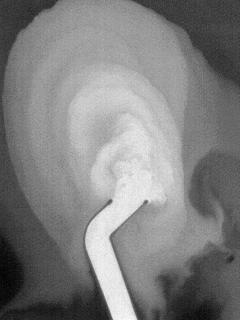

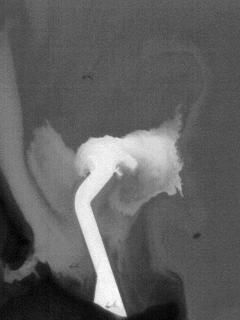

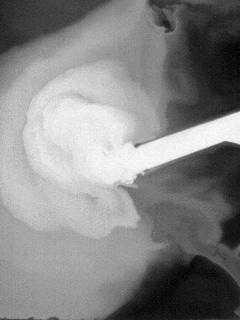

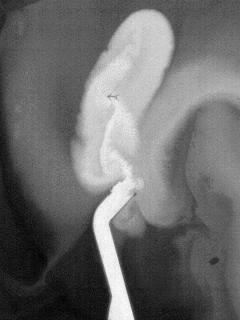

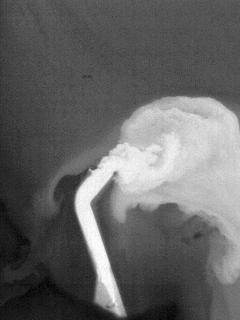

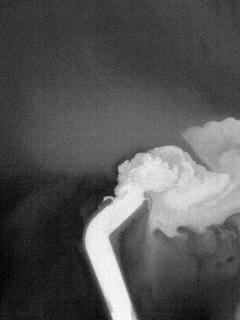

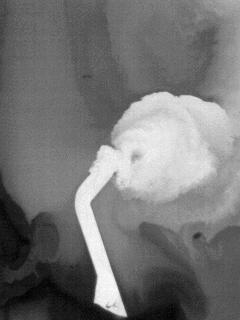

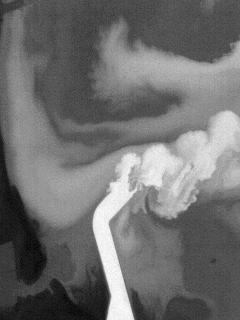

In [5]:
"""
We rescale the images to take values in the range [0, 1].
"""
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)
"""
Let's visualize a few sample images:
"""
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

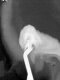

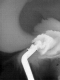

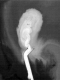

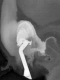

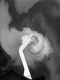

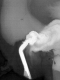

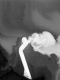

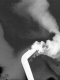

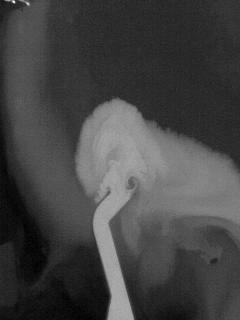

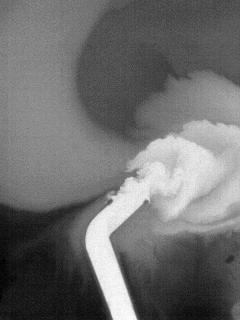

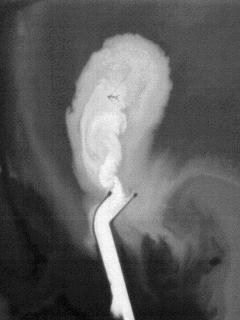

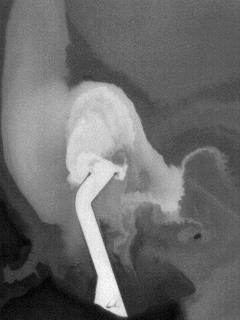

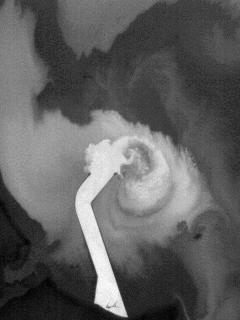

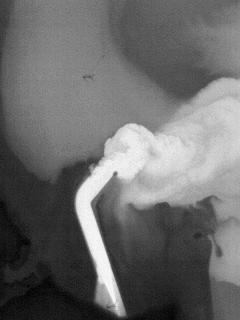

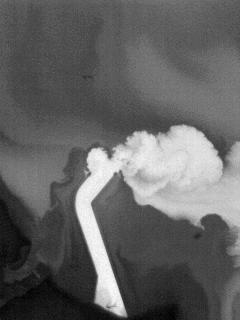

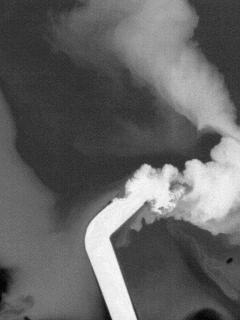

In [6]:
"""
## Crop and resize images
Let's process image data.
First, we convert our images from the RGB color space to the
[YUV colour space](https://en.wikipedia.org/wiki/YUV).
For the input data (low-resolution images),
we crop the image, retrieve the `y` channel (luninance),
and resize it with the `area` method (use `BICUBIC` if you use PIL).
We only consider the luminance channel
in the YUV color space because humans are more sensitive to
luminance change.
For the target data (high-resolution images), we just crop the image
and retrieve the `y` channel.
"""
# Use TF Ops to process.
# def process_input(input, input_size, upscale_factor):
#     input = tf.image.rgb_to_yuv(input)
#     last_dimension_axis = len(input.shape) - 1
#     y, u, v = tf.split(input, 3, axis=last_dimension_axis)
#     return tf.image.resize(y, [input_size, input_size], method="area")
# def process_target(input):
#     input = tf.image.rgb_to_yuv(input)
#     last_dimension_axis = len(input.shape) - 1
#     y, u, v = tf.split(input, 3, axis=last_dimension_axis)
#     return y
# train_ds = train_ds.map(
#     lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
# )
train_ds = train_ds.map(
    lambda x: (tf.image.resize(x, [input_size1, input_size2], method="area"), x)
)
train_ds = train_ds.prefetch(buffer_size=32)
# valid_ds = valid_ds.map(
#     lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
# )
valid_ds = valid_ds.map(
    lambda x: (tf.image.resize(x, [input_size1, input_size2], method="area"), x)
)
valid_ds = valid_ds.prefetch(buffer_size=32)
"""
Let's take a look at the input and target data.
"""
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [7]:
"""
## Build a model
Compared to the paper, we add one more layer and we use the `relu` activation function
instead of `tanh`.
It achieves better performance even though we train the model for fewer epochs.
"""
def get_model(upscale_factor=4, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [8]:
"""
## Define utility functions
We need to define several utility functions to monitor our results:
- `plot_results` to plot an save an image.
- `get_lowres_image` to convert an image to its low-resolution version.
- `upscale_image` to turn a low-resolution image to
a high-resolution version reconstructed by the model.
In this function, we use the `y` channel from the YUV color space
as input to the model and then combine the output with the
other channels to obtain an RGB image.
"""

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower",cmap="rainbow")#plt.cm.rainbow

    plt.title(title)#标注标题
    # zoom-factor: 2.0, location: upper-left=2
    axins = zoomed_inset_axes(ax, 3, loc=2)
    axins.imshow(img_array[::-1], origin="lower",cmap="rainbow")

    # Specify the limits.
    x1, x2, y1, y2 = 120,170,90,140#200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")#loc1=1, loc2=3
    plt.savefig(str(prefix) + "-" + title + ".tiff",dpi=300)
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [9]:
test_path = os.path.join(pathJPG, "test")
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)
"""
## Define callbacks to monitor training
The `ESPCNCallback` object will compute and display
the [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) metric.
This is the main metric we use to evaluate super-resolution performance.
"""
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

"""
Define `ModelCheckpoint` and `EarlyStopping` callbacks.
"""
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./tmp/checkpoint"#这个地方必须加./否则会提示PermissionDenied创建文件夹失败

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 61,680
Trainable params: 61,680
Non-trainable params: 0
_________________________________________________________

Epoch 1/100
1088/1088 - 338s - loss: 0.0022 - val_loss: 2.7206e-04
Mean PSNR for epoch: 35.64


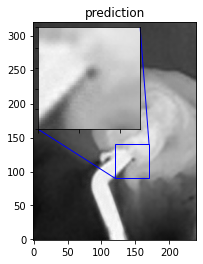

Epoch 2/100
1088/1088 - 297s - loss: 2.7358e-04 - val_loss: 2.4460e-04
Mean PSNR for epoch: 36.10
Epoch 3/100
1088/1088 - 282s - loss: 2.7625e-04 - val_loss: 2.3380e-04
Mean PSNR for epoch: 36.31
Epoch 4/100
1088/1088 - 294s - loss: 2.4091e-04 - val_loss: 2.2469e-04
Mean PSNR for epoch: 36.48
Epoch 5/100
1088/1088 - 335s - loss: 2.3801e-04 - val_loss: 2.2317e-04
Mean PSNR for epoch: 36.50
Epoch 6/100
1088/1088 - 305s - loss: 2.3738e-04 - val_loss: 2.1637e-04
Mean PSNR for epoch: 36.64
Epoch 7/100
1088/1088 - 303s - loss: 2.2394e-04 - val_loss: 2.3517e-04
Mean PSNR for epoch: 36.29
Epoch 8/100
1088/1088 - 314s - loss: 2.2732e-04 - val_loss: 2.1046e-04
Mean PSNR for epoch: 36.76
Epoch 9/100
1088/1088 - 400s - loss: 2.1949e-04 - val_loss: 2.0841e-04
Mean PSNR for epoch: 36.80
Epoch 10/100
1088/1088 - 411s - loss: 2.4045e-04 - val_loss: 2.1839e-04
Mean PSNR for epoch: 36.60
Epoch 11/100
1088/1088 - 391s - loss: 2.1838e-04 - val_loss: 2.1118e-04
Mean PSNR for epoch: 36.75
Epoch 12/100
1088/

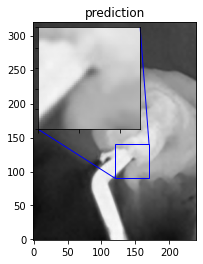

Epoch 22/100
1088/1088 - 308s - loss: 2.0780e-04 - val_loss: 2.0203e-04
Mean PSNR for epoch: 36.94
Epoch 23/100
1088/1088 - 311s - loss: 2.0548e-04 - val_loss: 2.0062e-04
Mean PSNR for epoch: 36.96
Epoch 24/100
1088/1088 - 303s - loss: 2.0477e-04 - val_loss: 1.9975e-04
Mean PSNR for epoch: 36.99
Epoch 25/100
1088/1088 - 323s - loss: 2.0465e-04 - val_loss: 1.9941e-04
Mean PSNR for epoch: 37.00
Epoch 26/100
1088/1088 - 333s - loss: 2.0216e-04 - val_loss: 1.9958e-04
Mean PSNR for epoch: 37.00
Epoch 27/100
1088/1088 - 376s - loss: 2.0270e-04 - val_loss: 1.9830e-04
Mean PSNR for epoch: 37.02
Epoch 28/100
1088/1088 - 319s - loss: 2.0068e-04 - val_loss: 1.9958e-04
Mean PSNR for epoch: 37.00
Epoch 29/100
1088/1088 - 320s - loss: 2.0310e-04 - val_loss: 1.9681e-04
Mean PSNR for epoch: 37.06
Epoch 30/100
1088/1088 - 313s - loss: 2.0529e-04 - val_loss: 1.9772e-04
Mean PSNR for epoch: 37.05
Epoch 31/100
1088/1088 - 348s - loss: 2.0518e-04 - val_loss: 1.9770e-04
Mean PSNR for epoch: 37.03
Epoch 32/1

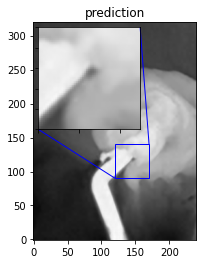

Epoch 42/100
1088/1088 - 285s - loss: 1.9775e-04 - val_loss: 1.9472e-04
Mean PSNR for epoch: 37.08
Epoch 43/100
1088/1088 - 284s - loss: 1.9789e-04 - val_loss: 1.9378e-04
Mean PSNR for epoch: 37.13
Epoch 44/100
1088/1088 - 287s - loss: 1.9644e-04 - val_loss: 1.9343e-04
Mean PSNR for epoch: 37.13
Epoch 45/100
1088/1088 - 286s - loss: 1.9679e-04 - val_loss: 1.9349e-04
Mean PSNR for epoch: 37.12
Epoch 46/100
1088/1088 - 287s - loss: 1.9647e-04 - val_loss: 1.9680e-04
Mean PSNR for epoch: 37.07
Epoch 47/100
1088/1088 - 286s - loss: 1.9783e-04 - val_loss: 1.9321e-04
Mean PSNR for epoch: 37.15
Epoch 48/100
1088/1088 - 286s - loss: 1.9671e-04 - val_loss: 1.9576e-04
Mean PSNR for epoch: 37.08
Epoch 49/100
1088/1088 - 284s - loss: 1.9574e-04 - val_loss: 1.9304e-04
Mean PSNR for epoch: 37.14
Epoch 50/100
1088/1088 - 286s - loss: 2.2348e-04 - val_loss: 2.0514e-04
Mean PSNR for epoch: 36.88
Epoch 51/100
1088/1088 - 290s - loss: 2.0289e-04 - val_loss: 1.9898e-04
Mean PSNR for epoch: 37.01
Epoch 52/1

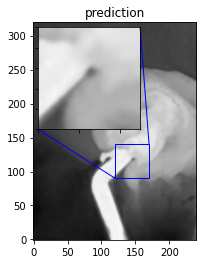

Epoch 62/100
1088/1088 - 283s - loss: 1.9516e-04 - val_loss: 1.9220e-04
Mean PSNR for epoch: 37.16
Epoch 63/100
1088/1088 - 285s - loss: 1.9566e-04 - val_loss: 1.9228e-04
Mean PSNR for epoch: 37.15
Epoch 64/100
1088/1088 - 288s - loss: 1.9488e-04 - val_loss: 1.9158e-04
Mean PSNR for epoch: 37.18
Epoch 65/100
1088/1088 - 297s - loss: 1.9388e-04 - val_loss: 1.9212e-04
Mean PSNR for epoch: 37.15
Epoch 66/100
1088/1088 - 296s - loss: 1.9445e-04 - val_loss: 1.9148e-04
Mean PSNR for epoch: 37.17
Epoch 67/100
1088/1088 - 284s - loss: 1.9335e-04 - val_loss: 1.9175e-04
Mean PSNR for epoch: 37.17
Epoch 68/100
1088/1088 - 284s - loss: 1.9442e-04 - val_loss: 1.9147e-04
Mean PSNR for epoch: 37.18
Epoch 69/100
1088/1088 - 288s - loss: 1.9409e-04 - val_loss: 1.9090e-04
Mean PSNR for epoch: 37.19
Epoch 70/100
1088/1088 - 284s - loss: 1.9292e-04 - val_loss: 1.9114e-04
Mean PSNR for epoch: 37.18
Epoch 71/100
1088/1088 - 286s - loss: 1.9317e-04 - val_loss: 1.9103e-04
Mean PSNR for epoch: 37.18
Epoch 72/1

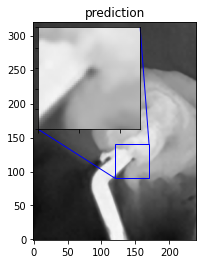

Epoch 82/100
1088/1088 - 286s - loss: 1.9551e-04 - val_loss: 1.9019e-04
Mean PSNR for epoch: 37.20
Epoch 83/100
1088/1088 - 284s - loss: 1.9232e-04 - val_loss: 1.8995e-04
Mean PSNR for epoch: 37.21
Epoch 84/100
1088/1088 - 285s - loss: 1.9192e-04 - val_loss: 1.9016e-04
Mean PSNR for epoch: 37.20
Epoch 85/100
1088/1088 - 285s - loss: 1.9223e-04 - val_loss: 1.9002e-04
Mean PSNR for epoch: 37.19
Epoch 86/100
1088/1088 - 282s - loss: 1.9146e-04 - val_loss: 1.8990e-04
Mean PSNR for epoch: 37.21
Epoch 87/100
1088/1088 - 284s - loss: 1.9286e-04 - val_loss: 1.8998e-04
Mean PSNR for epoch: 37.20
Epoch 88/100
1088/1088 - 284s - loss: 1.9198e-04 - val_loss: 1.8945e-04
Mean PSNR for epoch: 37.21
Epoch 89/100
1088/1088 - 291s - loss: 1.9202e-04 - val_loss: 1.9020e-04
Mean PSNR for epoch: 37.21
Epoch 90/100
1088/1088 - 283s - loss: 1.9163e-04 - val_loss: 1.8983e-04
Mean PSNR for epoch: 37.20
Epoch 91/100
1088/1088 - 288s - loss: 1.9170e-04 - val_loss: 1.9016e-04
Mean PSNR for epoch: 37.21
Epoch 92/1

In [10]:
## Train the model
epochs = 100
model.compile(
    optimizer=optimizer, loss=loss_fn,
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

## Run model prediction and plot the results
#Let's compute the reconstructed version of 50 images from the test set and save the results.

In [11]:
#Hash值对比#没调试成功
def cmpHash(img1,img2):
    hash_str1=''
    hash_str2=''
    #求平均灰度
    #avg1= sum(img1) / len(img1)
    #灰度大于平均值为1相反为0生成图片的hash值
    
    print(type(img1))
    print(img1.shape)
    
    for i in img1:
        if  i>avg1:
            hash_str1=hash_str1+'1'
        else:
            hash_str1=hash_str1+'0'
    avg2= sum(img2) / len(img2)
    #灰度大于平均值为1相反为0生成图片的hash值
    for j in img2:
        if  j>avg2:
            hash_str2=hash_str2+'1'
        else:
            hash_str2=hash_str2+'0'  
    n=0
    #hash长度不同则返回-1代表传参出错
    if len(hash_str1)!=len(hash_str2):
        return -1
    #遍历判断
    for i in range(len(hash_str1)):
        #不相等则n计数+1，n最终为相似度
        if hash_str1[i]!=hash_str2[i]:
            n=n+1
    return n/len(hash_str1)

In [ ]:
test_path =pathJPG+"\\test"
"""
We prepare a dataset of test image paths that we will use for
visual evaluation at the end of this example.
"""
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)
total_bicubic_psnr = 0.0
total_test_psnr = 0.0
for index, test_img_path in enumerate(test_img_paths):#[49:50]
    #select 50 images as result examples.
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)

    plot_results(lowres_img, index, "lowRes")
    plot_results(highres_img, index, "highRes")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 500))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 500))

## Apply the trained model to SR the Landsat8 remote sensing SST iamges.
#Let's compute the reconstructed version of Landsat8 images.

upscale_factor is 4.00
Date is 2022-12-19Rainbow
(1056, 816)
PSNR of predict and Bicubic is 35.3615


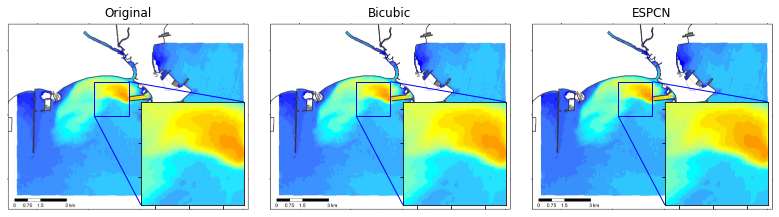

Avg. PSNR of reconstructions is 35.3615


In [13]:
def getfile(path,suffix,character):
    files=os.listdir(path)
    files.sort()
    filelist=[]
    for file in files:
        if not os.path.isdir(path+file) and (character in file) and (file.endswith(suffix)):
            f_name=str(file)
            tr="\\"
            filename=path+tr+f_name
            filelist.append(filename)
    return filelist

print("upscale_factor is %.2f" % upscale_factor)
img_path=getfile("F:\\phd_models_ML\\jupyterDir\\super-resolution\\HaiyangLandsat8SST\\HaiyangLandsat8SST_Rainbow",".jpg","Rainbow") 
total_test_psnr = 0.0
for image in img_path:
    img = load_img(image)
    date=image.split("\\")[-1]
    date=date.rsplit(".jpg")[0]
    print("Date is "+date)
    print(img.size)
    lowres_input = get_lowres_image(img, 1)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    Bicubic_img = lowres_input.resize((w, h),Image.BICUBIC)
    Bicubic_img_arr = img_to_array(Bicubic_img)

    prediction = upscale_image(model, lowres_input)
    predict_img_arr = img_to_array(prediction)
    test_psnr = tf.image.psnr(predict_img_arr, Bicubic_img_arr, max_val=255)
    total_test_psnr += test_psnr
    print("PSNR of predict and Bicubic is %.4f" % test_psnr)

    def plot_results1(imgList,title,x1x2y1y2,loc12,location):
        plt.rcParams['figure.figsize'] = [15, 10]
        Nimg=len(imgList)+1  
        fig,__ = plt.subplots(1,2)
        fig.tight_layout()
        for index, img in enumerate(imgList):  
            """Plot the result with zoom-in area."""
            img_array = img_to_array(img)
            img_array = img_array.astype("float32") / 255.0
            # Create a new figure with a default 111 subplot.
            ax = plt.subplot(1,Nimg,index+1)
            im = ax.imshow(img_array[::-1], origin="lower",cmap="rainbow")#plt.cm.rainbow
            plt.axis('off')

            plt.title(title[index])#标注标题
            # zoom-factor: 2.0, location: upper-left=2
            axins = zoomed_inset_axes(ax, 3, loc=location)
            axins.imshow(img_array[::-1], origin="lower",cmap="rainbow")

            # Apply the x-limits.
            axins.set_xlim(x1x2y1y2[index][0], x1x2y1y2[index][1])
            # Apply the y-limits.
            axins.set_ylim(x1x2y1y2[index][2], x1x2y1y2[index][3])
            plt.yticks(visible=False)
            plt.xticks(visible=False)

            # Make the line.
            mark_inset(ax, axins, loc1=loc12[0], loc2=loc12[1], fc="none", ec="blue")#loc1=1, loc2=3
        plt.savefig(date+"_"+title[-1] + ".png",dpi=300)
        plt.show()
    plot_results1([lowres_input,Bicubic_img,prediction],["Original","Bicubic","ESPCN"],
                  [[380,530,410,560],[4*380,4*530,4*410,4*560],[4*380,4*530,4*410,4*560]],
                  [1,3],4)
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / len(img_path)))

Date is 2022-12-19Rainbow
(1056, 816)
PSNR of predict and UAV measure is 16.6353
PSNR of Original and UAV_Lr measure is 17.6738
PSNR of Original and UAV measure is 16.7767


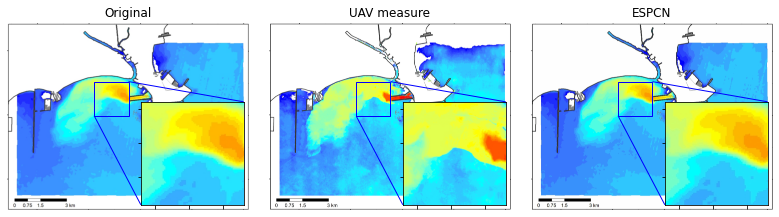

Avg. PSNR of reconstructions is 68.6321


In [38]:
imgUAV_path=getfile("F:\\phd_models_ML\\jupyterDir\\super-resolution\\HaiyangLandsat8SST\\HaiyangLandsat8SST_Rainbow",".jpg","UAV")
imgUAV=load_img(imgUAV_path[0])
imgUAV_Lr=load_img(imgUAV_path[1])

for image in img_path:
    img = load_img(image)
    date=image.split("\\")[-1]
    date=date.rsplit(".jpg")[0]
    print("Date is "+date)
    print(img.size)
    lowres_input = get_lowres_image(img, 1)
    w = lowres_input.size[0] * 4
    h = lowres_input.size[1] * 4
    Bicubic_img = lowres_input.resize((w, h),Image.BICUBIC)
    Bicubic_img_arr = img_to_array(Bicubic_img)
    
    UAV_img_arr = img_to_array(get_lowres_image(imgUAV, 1))
    UAV_Lr_img_arr = img_to_array(get_lowres_image(imgUAV_Lr, 1))

    prediction = upscale_image(model, lowres_input)
    predict_img_arr = img_to_array(prediction)
    test_psnr = tf.image.psnr(predict_img_arr, UAV_img_arr, max_val=255)
    
    test_psnr_Lr = tf.image.psnr(img_to_array(lowres_input), UAV_Lr_img_arr, max_val=255)
    bicubic_psnr = tf.image.psnr(Bicubic_img_arr, UAV_img_arr, max_val=255)
    
    total_test_psnr += test_psnr
    print("PSNR of predict and UAV measure is %.4f" % test_psnr)
    print("PSNR of Original and UAV_Lr measure is %.4f" % test_psnr_Lr)
    print("PSNR of Original and UAV measure is %.4f" % bicubic_psnr)

    def plot_results1(imgList,title,x1x2y1y2,loc12,location):
        plt.rcParams['figure.figsize'] = [15, 10]
        Nimg=len(imgList)+1  
        fig,__ = plt.subplots(1,2)
        fig.tight_layout()
        for index, img in enumerate(imgList):  
            """Plot the result with zoom-in area."""
            img_array = img_to_array(img)
            img_array = img_array.astype("float32") / 255.0
            # Create a new figure with a default 111 subplot.
            ax = plt.subplot(1,Nimg,index+1)
            im = ax.imshow(img_array[::-1], origin="lower",cmap="rainbow")#plt.cm.rainbow
            plt.axis('off')

            plt.title(title[index])#标注标题
            # zoom-factor: 2.0, location: upper-left=2
            axins = zoomed_inset_axes(ax, 3, loc=location)
            axins.imshow(img_array[::-1], origin="lower",cmap="rainbow")

            # Apply the x-limits.
            axins.set_xlim(x1x2y1y2[index][0], x1x2y1y2[index][1])
            # Apply the y-limits.
            axins.set_ylim(x1x2y1y2[index][2], x1x2y1y2[index][3])
            plt.yticks(visible=False)
            plt.xticks(visible=False)

            # Make the line.
            mark_inset(ax, axins, loc1=loc12[0], loc2=loc12[1], fc="none", ec="blue")#loc1=1, loc2=3
        plt.savefig(date+"_"+title[-1] + ".tif",dpi=300)
        plt.show()
    plot_results1([lowres_input,imgUAV,prediction],["Original","UAV measure","ESPCN"],
                  [[380,530,410,560],[4*380,4*530,4*410,4*560],[4*380,4*530,4*410,4*560]],
                  [1,3],4)
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / len(img_path)))

(341, 446)
<class 'numpy.ndarray'>
12.32402


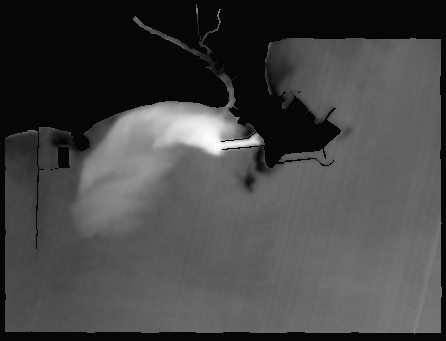

(1364, 1784, 3)


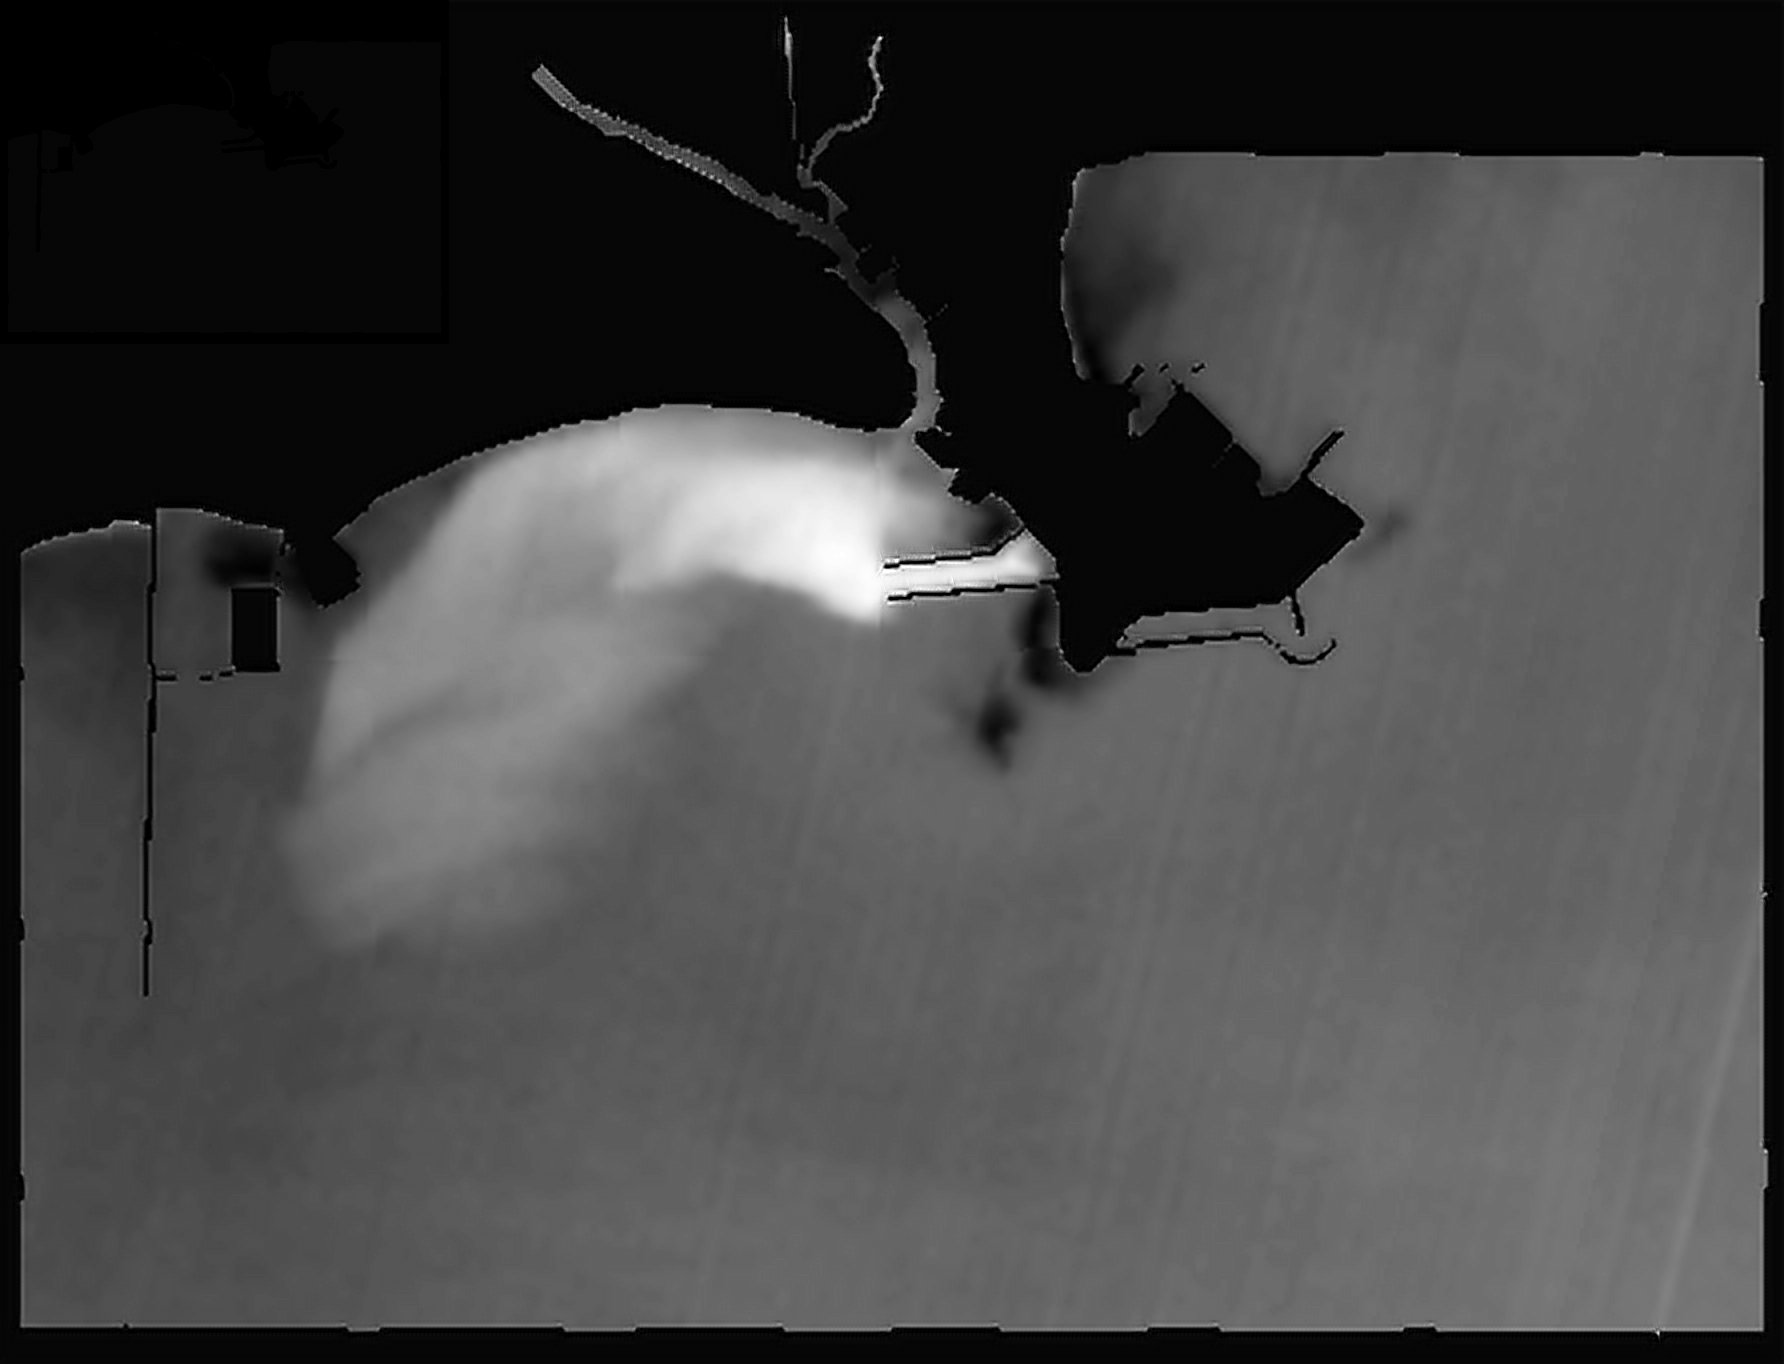

<Figure size 1080x720 with 0 Axes>

In [37]:
imgUAV=load_img("F:\\phd_models_ML\\jupyterDir\\super-resolution\\HaiyangLandsat8SST\\2022-12-19Landsat8.jpg")
lowres_input = get_lowres_image(imgUAV, 1)


data=np.loadtxt("F:\\phd_models_ML\\jupyterDir\\super-resolution\\HaiyangLandsat8SST\\2022-12-19Landsat8.txt")
print(data.shape)
print(type(data))
data1=np.vstack((data,data,data)).reshape(341, 446,3)
print(np.max(data))# nearly 12.5
#sys.exit()
index=[]
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if data[i][j]==-9999:
            data1[i][j]=[0,0,0]
            index.append([i,j])
        else:
            data1[i][j]=[data[i][j]*20,data[i][j]*20,data[i][j]*20]
            #multi by 20 is to rescale the data to 255
imgLandsat8=array_to_img(data1)
lowres_input = get_lowres_image(imgLandsat8, 1)

display(array_to_img(lowres_input))
plt.savefig("2022-12-19Landsat8LR.tif",dpi=300)
prediction = upscale_image(model, lowres_input)
predict_img_arr = img_to_array(prediction)/20
print(predict_img_arr.shape)
for ii in index:
    predict_img_arr[ii[0]:ii[0]+4,ii[1]:ii[1]+4,:]=0

np.savetxt("D:\\2022WinterHY\\Arcgis-Haiyang2022\\UAVtifAdjust2022\\state2landsatESPCN.txt",predict_img_arr[:,:,0])
display(array_to_img(predict_img_arr))  
plt.savefig("2022-12-19Landsat8ESPCNx4.tif",dpi=300)